## Structure and populate the subfolders

In [1]:
import os
import glob

from torch import normal

data_dir = "./"

#create training dir
training_dir = os.path.join(data_dir,"training")
if not os.path.isdir(training_dir):
  os.mkdir(training_dir)

#create dog in training
jaundice_training_dir = os.path.join(training_dir,"jaundice")
if not os.path.isdir(jaundice_training_dir):
  os.mkdir(jaundice_training_dir)

#create cat in training
normal_training_dir = os.path.join(training_dir,"normal")
if not os.path.isdir(normal_training_dir):
  os.mkdir(normal_training_dir)

#create validation dir
validation_dir = os.path.join(data_dir,"validation")
if not os.path.isdir(validation_dir):
  os.mkdir(validation_dir)

#create dog in validation
jaundice_validation_dir = os.path.join(validation_dir,"jaundice")
if not os.path.isdir(jaundice_validation_dir):
  os.mkdir(jaundice_validation_dir)

#create cat in validation
normal_validation_dir = os.path.join(validation_dir,"normal")
if not os.path.isdir(normal_validation_dir):
  os.mkdir(normal_validation_dir)

### Shuffle newly aquired data in folder

In [2]:
import shutil
from numpy import size

split_size = 0.80
jaundice_imgs_size = len(glob.glob("./jaundice/jaundice/*"))
normal_imgs_size = len(glob.glob("./normal/normal/*"))


for i,img in enumerate(glob.glob("./jaundice/jaundice/*")):
  if i < (jaundice_imgs_size * split_size):
    shutil.move(img,jaundice_training_dir)

  else:
    shutil.move(img,jaundice_validation_dir)


for i,img in enumerate(glob.glob("./normal/normal/*")):
  if i < (normal_imgs_size * split_size):
    shutil.move(img,normal_training_dir)
  else:
    shutil.move(img,normal_validation_dir)

## plot some examples


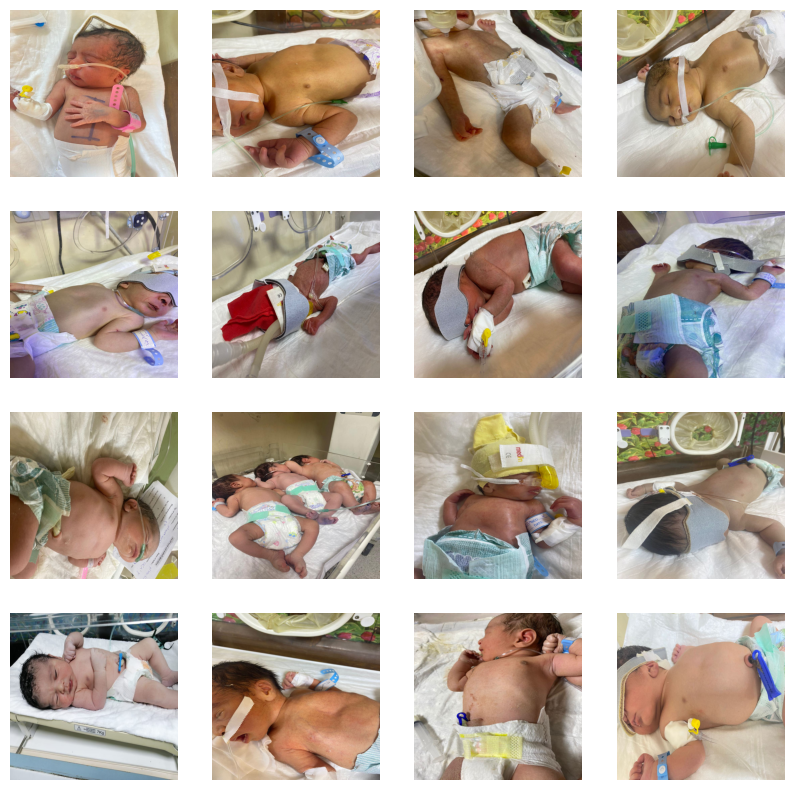

In [3]:
import matplotlib.pyplot as plt
import numpy as np

from IPython.core.pylabtools import figsize

samples_jaundice = [os.path.join(jaundice_training_dir,np.random.choice(a = os.listdir(jaundice_training_dir),size = 1)[0]) for _ in range(8)]
samples_normal = [os.path.join(normal_training_dir,np.random.choice(a = os.listdir(normal_training_dir),size = 1)[0]) for _ in range(8)]

nrows = 4
ncols = 4

fig, ax = plt.subplots(nrows,ncols,figsize = (10,10))
ax = ax.flatten()

for i in range(nrows*ncols):
  if i < 8:
    pic = plt.imread(samples_jaundice[i%8])
    ax[i].imshow(pic)
    ax[i].set_axis_off()
  else:
    pic = plt.imread(samples_normal[i%8])
    ax[i].imshow(pic)
    ax[i].set_axis_off()
plt.show()

In [4]:
# our custom transformer to detect only skin

import cv2
import numpy as np

def custom_skin_detector(img):
    img = np.array(img)
    img_HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

#skin color range for h in hsv
    HSV_mask = cv2.inRange(img_HSV[:,:,0], np.array((0)), np.array((17)))
    HSV_mask = cv2.morphologyEx(HSV_mask,cv2.MORPH_OPEN,np.ones((3,3),np.uint8))

    #converting from gbr to YCbCr color space
    img_YCrCb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)

    #putting all values of y to 0
    img_YCrCb[:,:,0] = 0

    #skin color range for ycrcb color space 
    YCrCb_mask = cv2.inRange(img_YCrCb, np.array((0, 135, 85)), np.array((255,180,135))) 
    YCrCb_mask = cv2.morphologyEx(YCrCb_mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))

    #global mask made from YCrCb mask and hsv mask
    global_mask=cv2.bitwise_and(YCrCb_mask,HSV_mask)
    global_mask=cv2.medianBlur(global_mask,3)
    global_mask = cv2.morphologyEx(global_mask, cv2.MORPH_OPEN, np.ones((4,4), np.uint8))
    global_img = cv2.bitwise_and(img,img,mask=global_mask)
    global_img = cv2.cvtColor(global_img,cv2.COLOR_BGR2RGB)
    return global_img

## Create dataloader

Now we are going to do 3 things:

1. Let’s preprocess our data using the compose method, which is a simple method to apply multiple preprocessing functions like normalization and data augmentation to our dataset.
2. Let’s use ImageFolder to create a pytorch dataset. PyTorch infers the class automatically if the subdirectories structure is well defined (as in our case).
3. Use the DataLoader to slice our data in batches.

In [5]:
import os
import cv2
import torch
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms

# Custom dataset class to apply skin detection to images
class SkinDetectionDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.data = []  # A list to store (image, class_label) pairs
        for class_folder in os.listdir(folder_path):
            class_folder_path = os.path.join(folder_path, class_folder)
            if os.path.isdir(class_folder_path):
                class_label = class_folder
                for filename in os.listdir(class_folder_path):
                    if filename.endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                        image_path = os.path.join(class_folder_path, filename)
                        self.data.append((image_path, class_label))
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, class_label = self.data[idx]
        image = cv2.imread(image_path)  # Load the image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

        # Apply the skin detection function
        skin_detected_image = custom_skin_detector(image)

        if self.transform:
            skin_detected_image = self.transform(skin_detected_image)

        return skin_detected_image, class_label


In [6]:
traindir = "./training"
testdir = "./validation"

# derfine a transformation to convert the image to pytorch tensor and resize it to 224
transform = transforms.Compose([transforms.ToTensor(),transforms.Resize((224,224))])

# Create an instance of the custom dataset
train_data = SkinDetectionDataset(traindir, transform= transform)
test_data = SkinDetectionDataset(testdir,transform = transform)

# Create a DataLoader for the dataset
batch_size = 16
trainloader = DataLoader(train_data,batch_size=batch_size,shuffle = True)
testloader = DataLoader(test_data,batch_size=batch_size,shuffle=True)

In [7]:
# import torch
# import torch.utils.data
# import torchvision
# from torchvision import datasets, transforms

# traindir = "./training"
# testdir = "./validation"

# #transformations
# # train_transforms = transforms.Compose([transforms.Resize((224,224)),
# #                                        transforms.ToTensor(),
# #                                        torchvision.transforms.Normalize(
# #                                            mean=[0.485, 0.456, 0.406],
# #                                            std=[0.229, 0.224, 0.225],
# #     ),

# train_transforms = transforms.Compose([transforms.Resize((224,224)),
#                                        transforms.Lambda(custom_skin_detector),
#                                        transforms.ToTensor(),
#                                        ])
# # test_transforms = transforms.Compose([transforms.Resize((224,224)),
# #                                       transforms.ToTensor(),
# #                                       torchvision.transforms.Normalize(
# #                                           mean=[0.485, 0.456, 0.406],
# #                                           std=[0.229, 0.224, 0.225],
# #     ),
# #                                       ])
# test_transforms = transforms.Compose([
#                                       transforms.Lambda(custom_skin_detector),
#                                       transforms.ToTensor(),
#                                       ])

# #datasets
# train_data = datasets.ImageFolder(traindir,transform=train_transforms)
# test_data = datasets.ImageFolder(testdir,transform=test_transforms)

# #dataloader
# trainloader = torch.utils.data.DataLoader(train_data, shuffle = True, batch_size=16)
# testloader = torch.utils.data.DataLoader(test_data, shuffle = True, batch_size=16)

In [26]:
# import cv2
# import numpy as np
# import torch
# import torchvision.transforms as transforms
# import torch.nn.functional as F

# # Load the image
# image_path = './training/normal/normal (1).jpg'
# image = cv2.imread(image_path)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# # Convert the image to YCbCr
# yCbCr_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)

# # Extract the CbCr channels
# CbCr_channels = yCbCr_image[:, :, 1:]

# # Convert the image to HSV
# hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

# # Extract the Hue channel
# hue_channel = hsv_image[:, :, 0]

# # You can use a pre-trained face detection model here, for example, using OpenCV's Haar Cascade:
# face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
# faces = face_cascade.detectMultiScale(image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

# # Define a function to apply face detection based on CbCr channels
# def detect_faces_CbCr(CbCr_image):
#     # Define a threshold for detecting faces based on the CbCr values
#     lower_bound = np.array([120, 133])
#     upper_bound = np.array([180, 173])

#     # Create a mask to select regions that fall within the CbCr range
#     mask = cv2.inRange(CbCr_image, lower_bound, upper_bound)

#     # Find contours in the mask
#     contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#     # Initialize an empty list to store detected face rectangles
#     detected_faces = []

#     for contour in contours:
#         # Get the bounding box for each contour
#         x, y, w, h = cv2.boundingRect(contour)

#         # Add the bounding box to the list of detected faces
#         detected_faces.append((x, y, x + w, y + h))

#     return detected_faces

# # Detect faces based on CbCr channels
# CbCr_faces = detect_faces_CbCr(CbCr_channels)

# # Display the image with CbCr face detection
# image_copy = image.copy()
# for (x, y, x2, y2) in CbCr_faces:
#     cv2.rectangle(image_copy, (x, y), (x2, y2), (0, 255, 0), 2)

# # Display the image with CbCr face detection
# cv2.imshow('CbCr Face Detection', image_copy)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# # You can also use the hue channel for face detection or other purposes
# # Detecting faces based on the hue channel is more challenging and may require additional techniques or models.


## training function

In [9]:
def make_train_step(model, optimizer, loss_fn):
  def train_step(x,y):
    #make prediction
    yhat = model(x) #forward pass
    #enter train mode
    model.train() # make model to train
    #compute loss
    loss = loss_fn(yhat,y) # calculate loss

    loss.backward() # backward propogation
    optimizer.step() #optimizer step
    optimizer.zero_grad() 
    #optimizer.cleargrads()

    return loss
  return train_step

## Our model used

In [10]:
from torchvision import datasets, models, transforms
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"
model = models.resnet50(pretrained=True)

model.eval()

#add a new final layer
with torch.no_grad():
  nr_filters = model.fc.in_features  #number of input features of last layer
  model.fc = nn.Linear(nr_filters, 1)

  model = model.to(device)

C:\Users\divij\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\divij\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\divij/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [07:18<00:00, 234kB/s]    


### Optimizer and make train step

In [11]:
from torch.nn.modules.loss import BCEWithLogitsLoss
from torch.optim import lr_scheduler

#loss
loss_fn = BCEWithLogitsLoss() #binary cross entropy with sigmoid, so no need to use sigmoid in the model

#optimizer
optimizer = torch.optim.Adam(model.fc.parameters())

#train step
train_step = make_train_step(model, optimizer, loss_fn)

## Train the model


In [12]:
def accuracy_fn(y_true, y_pred):
  correct = torch.sum((y_true == y_pred))
  acc = (correct/len(y_pred))*100
  return acc

In [13]:
# %%capture
# %pip install tqdm
from tqdm import tqdm

losses = []
val_losses = []

epoch_train_losses = []
epoch_test_losses = []

n_epochs = 1
early_stopping_tolerance = 3
early_stopping_threshold = 0.03

for epoch in range(n_epochs):
  print(f"epoch {epoch} is running")
  epoch_loss = 0
  for i ,data in tqdm(enumerate(trainloader), total = len(trainloader)): #iterate ovre batches
    x_batch , y_batch = data
    x_batch = x_batch.to(device) #move to gpu
    y_batch = y_batch.unsqueeze(1).float() #convert target to same nn output shape
    y_batch = y_batch.to(device)

    loss = train_step(x_batch, y_batch)
    epoch_loss += loss/len(trainloader)
    losses.append(loss)

  epoch_train_losses.append(epoch_loss)
  print('\nEpoch : {}, train loss : {}'.format(epoch+1,epoch_loss))

  #validation doesnt requires gradient
  with torch.no_grad():
    cum_loss = 0
    for data in testloader:
      x_batch,y_batch = data
      x_batch = x_batch.to(device)
      y_batch = y_batch.unsqueeze(1).float() #convert target to same nn output shape
      y_batch = y_batch.to(device)

      #model to eval mode
      model.eval()

      yhat = model(x_batch)
      val_loss = loss_fn(yhat,y_batch)
      print(f"accuracy: {accuracy_fn(yhat,y_batch)}")
      cum_loss += loss/len(testloader)
      val_losses.append(val_loss.item())


    epoch_test_losses.append(cum_loss)
    print('Epoch : {}, val loss : {}'.format(epoch+1,cum_loss))

    best_loss = min(epoch_test_losses)

    #save best model
    if cum_loss <= best_loss:
      best_model_wts = model.state_dict()

    #early stopping
    early_stopping_counter = 0
    if cum_loss > best_loss:
      early_stopping_counter +=1

    if (early_stopping_counter == early_stopping_tolerance) or (best_loss <= early_stopping_threshold):
      print("/nTerminating: early stopping")
      break #terminate training

#load best model
model.load_state_dict(best_model_wts)

epoch 0 is running


  0%|          | 0/38 [00:00<?, ?it/s]C:\Users\divij\AppData\Roaming\Python\Python311\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/38 [00:00<?, ?it/s]


AttributeError: 'tuple' object has no attribute 'unsqueeze'

## Inference

Prediction : normal


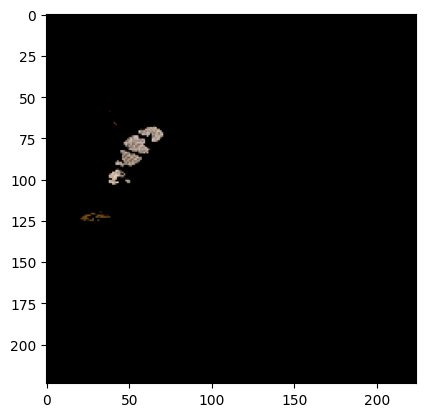

In [23]:
import matplotlib.pyplot as plt

def inference(test_data):
  idx = torch.randint(1, len(test_data), (1,))
  sample = torch.unsqueeze(test_data[idx][0], dim=0).to(device)

  if torch.sigmoid(model(sample)) < 0.5:
    print("Prediction : normal")
  else:
    print("Prediction : jaundice")


  plt.imshow(test_data[idx][0].permute(1, 2, 0))

inference(test_data)